In [1]:
import sys
import os

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from features.get_merged_dataframes import get_merged_dataframes

In [2]:
pair_1, pair_2 = "BTC_USDT", "DOT_USDT"

In [3]:
train_df, val_df, test_df = get_merged_dataframes(pair_1, pair_2)

start: 2020-08-18 23:00:00+00:00, end: 2025-04-09 17:54:00+00:00


Добавим колонку target - это close_y для следующей свечи

In [4]:
df = train_df.copy()

In [5]:
df['target'] = df['close_y'].shift(-1) / df['close_y']

In [6]:
df = df.iloc[:-1]

Будем обучаться на окне фиксированной длины, считать ошибку на валидации, сдвигать окно, заново учиться и считать ошибку на новой валидации и так далее

In [7]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm

validations_num = 3
train_valid_ratio = 4
N = len(df)

# Walk-Forward Optimisation, разобьем валидационную выборку на 3 части
valid_len = int(N / (validations_num + train_valid_ratio))
train_len = valid_len * train_valid_ratio

df_clean = df.sort_index()

In [8]:
target = 'target'

features = df.columns.drop(['date', 'target'])

catboost_rmse_scores = []

print(f"CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для {pair_2}, все признаки")
for i in tqdm(range(validations_num)):
    train_begin = i * valid_len
    train_end = train_len + i * valid_len
    val_end = min(train_len + (i+1) * valid_len, N)
    
    # Вомзможно стоит и 0:train_end; плюсы: можем знать долгосрочный тренд, минусы: дольше обучается
    train_data = df_clean.iloc[train_begin:train_end]
    val_data = df_clean.iloc[train_end:val_end]

    train_pool = Pool(data=train_data[features], label=train_data[target])
    val_pool = Pool(data=val_data[features], label=val_data[target])

    # Обучение
    model = CatBoostRegressor(iterations=100, depth=7, learning_rate=0.08, loss_function='RMSE', verbose=False)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    # Валидация
    val_predictions = model.predict(val_data[features])
    rmse = root_mean_squared_error(val_data[target], val_predictions)
    catboost_rmse_scores.append(rmse)

    print(f'Validation RMSE from {train_end} to {val_end}: {rmse}')

# Print average RMSE score
print(f'Average RMSE across all validation sets: {sum(catboost_rmse_scores) / len(catboost_rmse_scores)}')

CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для DOT_USDT, все признаки


 33%|█▎  | 1/3 [00:08<00:17,  8.77s/it]

Validation RMSE from 947624 to 1184530: 0.0015738957425674178


 67%|██▋ | 2/3 [00:15<00:07,  7.33s/it]

Validation RMSE from 1184530 to 1421436: 0.0010241547612555302


100%|████| 3/3 [00:21<00:00,  7.32s/it]

Validation RMSE from 1421436 to 1658342: 0.0006902721327094431
Average RMSE across all validation sets: 0.001096107545510797


In [9]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
print(importance_df.head(20))

               feature  importance
88    OSC_STOCH_K_ST_y   40.305327
23    OSC_STOCH_K_ST_x   11.087502
5    RAW_prev_return_x    8.030115
70   RAW_prev_return_y    7.398645
102       MOM_ATR_LT_y    2.821437
101       MOM_ATR_MT_y    2.552112
11         MA_EMA_MT_x    2.500669
13   MA_EMA_daily_LT_x    2.128827
60    VOL_CHAIKIN_MT_x    1.530949
50   BOL_BB_LOWER_MT_x    1.368064
84       OSC_MACD_MT_y    1.340474
46   BOL_BB_LOWER_ST_x    1.290903
52   BOL_BB_UPPER_LT_x    1.261686
59    VOL_CHAIKIN_ST_x    1.206379
74   MA_SMA_daily_LT_y    1.109718
10         MA_EMA_ST_x    1.100908
54   BOL_BB_LOWER_LT_x    1.046575
1               high_x    0.885315
100       MOM_ATR_ST_y    0.846939
12         MA_EMA_LT_x    0.823278


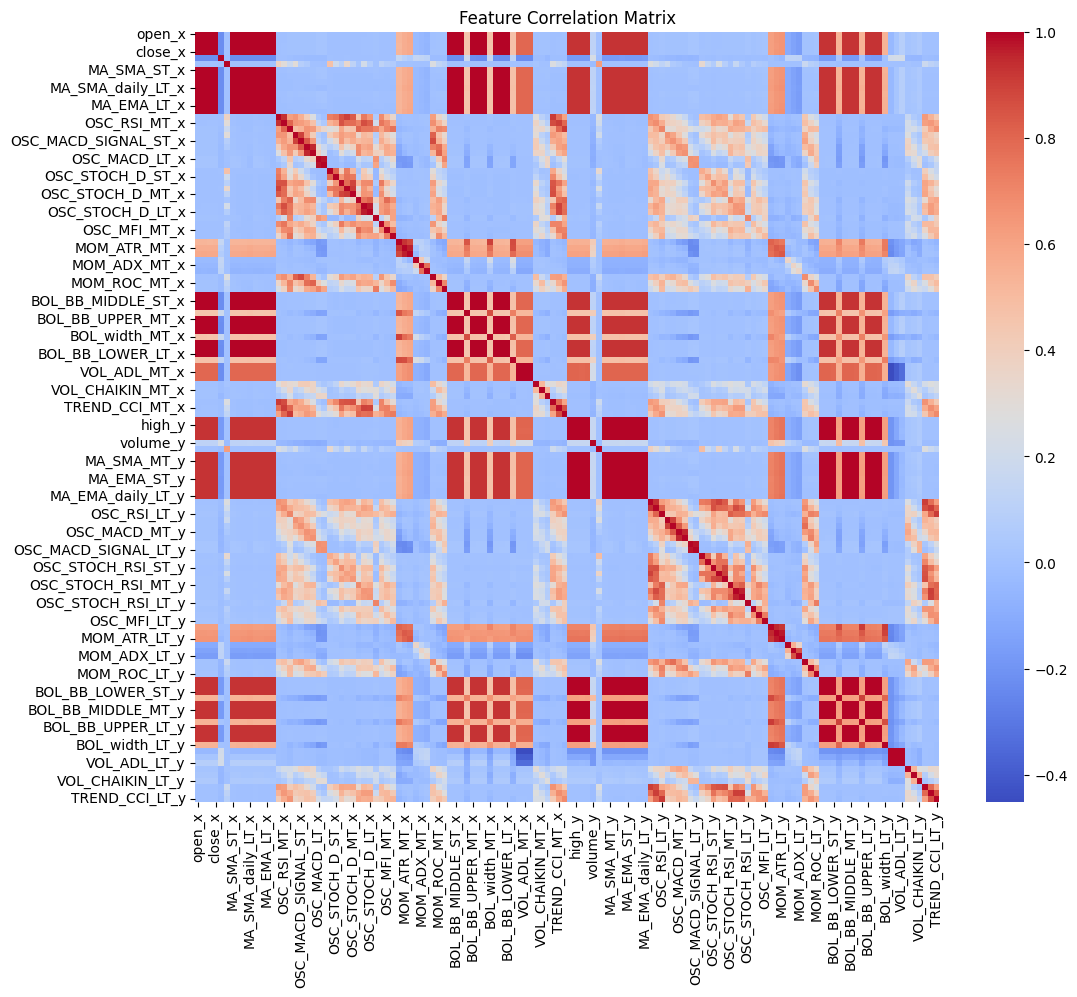

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

features = df.columns.drop(['date', 'target'])

# Compute the correlation matrix of your features
corr_matrix = df[features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

In [11]:
import numpy as np

threshold = 0.99

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

stacked_corr = filtered_corr.stack()

high_corr_pairs = stacked_corr[stacked_corr > threshold]

for (row, col), value in high_corr_pairs.items():
    print(f"Pair: ({row}, {col}) -> correlation: {value:.3f}")

Pair: (open_x, high_x) -> correlation: 1.000
Pair: (open_x, low_x) -> correlation: 1.000
Pair: (open_x, close_x) -> correlation: 1.000
Pair: (open_x, MA_SMA_ST_x) -> correlation: 1.000
Pair: (open_x, MA_SMA_MT_x) -> correlation: 1.000
Pair: (open_x, MA_SMA_LT_x) -> correlation: 1.000
Pair: (open_x, MA_SMA_daily_LT_x) -> correlation: 0.999
Pair: (open_x, MA_EMA_ST_x) -> correlation: 1.000
Pair: (open_x, MA_EMA_MT_x) -> correlation: 1.000
Pair: (open_x, MA_EMA_LT_x) -> correlation: 1.000
Pair: (open_x, MA_EMA_daily_LT_x) -> correlation: 0.999
Pair: (open_x, BOL_BB_UPPER_ST_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_MIDDLE_ST_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_LOWER_ST_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_UPPER_MT_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_MIDDLE_MT_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_LOWER_MT_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_UPPER_LT_x) -> correlation: 1.000
Pair: (open_x, BOL_BB_MIDDLE_LT_x) -> correlation: 1.000
Pa

In [12]:
high_corr_pairs

open_x              high_x               0.999997
                    low_x                0.999997
                    close_x              0.999996
                    MA_SMA_ST_x          0.999999
                    MA_SMA_MT_x          0.999950
                                           ...   
BOL_BB_UPPER_LT_y   BOL_BB_LOWER_LT_y    0.999716
BOL_BB_MIDDLE_LT_y  BOL_BB_LOWER_LT_y    0.999928
VOL_ADL_ST_y        VOL_ADL_MT_y         1.000000
                    VOL_ADL_LT_y         0.999996
VOL_ADL_MT_y        VOL_ADL_LT_y         0.999998
Length: 426, dtype: float64

In [13]:
import pandas as pd
import networkx as nx

pairs = list(high_corr_pairs.index)
G = nx.Graph()
G.add_edges_from(pairs)

all_features = set(df.columns) - set(['target', 'date'])
non_corr_features = all_features - set(G.nodes())

selected_corr_features = []
for component in nx.connected_components(G):
    representative = sorted(component)[0]
    selected_corr_features.append(representative)

non_corr_features = list(non_corr_features) + selected_corr_features

print("Minimal set of features:")
print(non_corr_features)

Minimal set of features:
['RAW_prev_return_x', 'MOM_ROC_MT_y', 'TREND_CCI_ST_x', 'MOM_ROC_LT_x', 'OSC_MACD_SIGNAL_ST_y', 'BOL_width_MT_y', 'VOL_CHAIKIN_LT_x', 'OSC_STOCH_K_ST_x', 'RAW_prev_return_y', 'OSC_STOCH_D_ST_y', 'OSC_STOCH_K_MT_x', 'MOM_ATR_LT_x', 'BOL_width_LT_x', 'MOM_ROC_LT_y', 'BOL_width_ST_x', 'volume_y', 'OSC_STOCH_D_ST_x', 'OSC_MFI_MT_y', 'OSC_STOCH_D_MT_x', 'MOM_ADX_LT_y', 'OSC_STOCH_D_LT_y', 'MOM_ADX_MT_x', 'MOM_ADX_MT_y', 'OSC_MFI_LT_y', 'TREND_CCI_LT_y', 'OSC_STOCH_K_ST_y', 'TREND_CCI_ST_y', 'TREND_CCI_MT_y', 'TREND_CCI_LT_x', 'MOM_ATR_ST_x', 'OSC_MACD_MT_x', 'OSC_STOCH_RSI_LT_y', 'MOM_ATR_MT_x', 'OSC_MACD_SIGNAL_LT_x', 'OSC_MACD_SIGNAL_MT_y', 'volume_x', 'OSC_MFI_ST_y', 'OSC_STOCH_D_MT_y', 'BOL_width_MT_x', 'OSC_STOCH_D_LT_x', 'OSC_STOCH_K_MT_y', 'OSC_MACD_SIGNAL_ST_x', 'OSC_STOCH_RSI_ST_y', 'MOM_ADX_ST_y', 'TREND_CCI_MT_x', 'OSC_RSI_MT_x', 'MOM_ROC_ST_y', 'OSC_RSI_ST_y', 'OSC_STOCH_RSI_MT_x', 'OSC_RSI_MT_y', 'VOL_CHAIKIN_MT_x', 'MOM_ROC_ST_x', 'OSC_STOCH_RSI_ST_x',

In [14]:
target = 'target'

non_corr_rmse_scores = []

print(f"CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для {pair_2}, нескоррелированные признаки")
for i in tqdm(range(validations_num)):
    train_begin = i * valid_len
    train_end = train_len + i * valid_len
    val_end = min(train_len + (i+1) * valid_len, N)
    
    # Вомзможно стоит и 0:train_end; плюсы: можем знать долгосрочный тренд, минусы: дольше обучается
    train_data = df_clean.iloc[train_begin:train_end]
    val_data = df_clean.iloc[train_end:val_end]

    train_pool = Pool(data=train_data[non_corr_features], label=train_data[target])
    val_pool = Pool(data=val_data[non_corr_features], label=val_data[target])

    # Обучение
    model = CatBoostRegressor(iterations=100, depth=7, learning_rate=0.08, loss_function='RMSE', verbose=False)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    # Валидация
    val_predictions = model.predict(val_data[non_corr_features])
    rmse = root_mean_squared_error(val_data[target], val_predictions)
    non_corr_rmse_scores.append(rmse)

    print(f'Validation RMSE from {train_end} to {val_end}: {rmse}')

# Print average RMSE score
print(f'Average RMSE across all validation sets: {sum(non_corr_rmse_scores) / len(non_corr_rmse_scores)}')

CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для DOT_USDT, нескоррелированные признаки


 33%|█▎  | 1/3 [00:05<00:11,  5.84s/it]

Validation RMSE from 947624 to 1184530: 0.001574055661259263


 67%|██▋ | 2/3 [00:09<00:04,  4.61s/it]

Validation RMSE from 1184530 to 1421436: 0.001025211903432712


100%|████| 3/3 [00:13<00:00,  4.57s/it]

Validation RMSE from 1421436 to 1658342: 0.0006903916116869328
Average RMSE across all validation sets: 0.0010965530587929693


In [15]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({'feature': non_corr_features, 'importance': feature_importances})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
print(importance_df.head(20))

                 feature  importance
25      OSC_STOCH_K_ST_y   37.885711
82     BOL_BB_LOWER_LT_x   13.261795
7       OSC_STOCH_K_ST_x   10.239702
8      RAW_prev_return_y    8.571758
0      RAW_prev_return_x    8.510449
62          MOM_ATR_ST_y    2.776968
83          VOL_ADL_LT_x    2.608062
77          MOM_ATR_LT_y    2.259455
73          MOM_ATR_MT_y    2.098614
85          VOL_ADL_LT_y    1.999492
84     BOL_BB_LOWER_LT_y    1.918210
58      VOL_CHAIKIN_ST_x    1.277810
34  OSC_MACD_SIGNAL_MT_y    1.219668
72          OSC_MFI_ST_x    0.755103
80         OSC_MACD_LT_y    0.753395
68      VOL_CHAIKIN_ST_y    0.528218
4   OSC_MACD_SIGNAL_ST_y    0.455598
48    OSC_STOCH_RSI_MT_x    0.432916
6       VOL_CHAIKIN_LT_x    0.425922
50      VOL_CHAIKIN_MT_x    0.424897


In [16]:
target = 'target'

ohlcv_rmse_scores = []

minimal_features = ['close_y']

print(f"CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для {pair_2}, нескоррелированные признаки")
for i in tqdm(range(validations_num)):
    train_begin = i * valid_len
    train_end = train_len + i * valid_len
    val_end = min(train_len + (i+1) * valid_len, N)
    
    # Вомзможно стоит и 0:train_end; плюсы: можем знать долгосрочный тренд, минусы: дольше обучается
    train_data = df_clean.iloc[train_begin:train_end]
    val_data = df_clean.iloc[train_end:val_end]

    train_pool = Pool(data=train_data[minimal_features], label=train_data[target])
    val_pool = Pool(data=val_data[minimal_features], label=val_data[target])

    # Обучение
    model = CatBoostRegressor(iterations=100, depth=7, learning_rate=0.08, loss_function='RMSE', verbose=False)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

    # Валидация
    val_predictions = model.predict(val_data[minimal_features])
    rmse = root_mean_squared_error(val_data[target], val_predictions)
    ohlcv_rmse_scores.append(rmse)

    print(f'Validation RMSE from {train_end} to {val_end}: {rmse}')

# Print average RMSE score
print(f'Average RMSE across all validation sets: {sum(ohlcv_rmse_scores) / len(ohlcv_rmse_scores)}')

CatBoost Regressor с RMSE функцией ошибки для предсказания close следующей свечи для DOT_USDT, нескоррелированные признаки


 33%|█▎  | 1/3 [00:01<00:02,  1.23s/it]

Validation RMSE from 947624 to 1184530: 0.0015875035448140236


 67%|██▋ | 2/3 [00:02<00:01,  1.29s/it]

Validation RMSE from 1184530 to 1421436: 0.0010387990760864347


100%|████| 3/3 [00:03<00:00,  1.24s/it]

Validation RMSE from 1421436 to 1658342: 0.0006912049882547102
Average RMSE across all validation sets: 0.0011058358697183894


А теперь сравним с бенчмарком - изменение цены 0 относительно предыдущего

In [20]:
print(f"Бенчмарк: close текущей свечи для предсказания close следующей свечи для {pair_2}")
prev_rmse_scores = []
for i in tqdm(range(validations_num)):
    train_begin = i * valid_len
    train_end = train_len + i * valid_len
    val_end = min(train_len + (i+1) * valid_len, N)
    
    val_data = df_clean.iloc[train_end+1:val_end]
    
    # Валидация
    val_predictions = np.ones(val_end - train_end - 1)
    rmse = root_mean_squared_error(val_data[target], val_predictions)
    prev_rmse_scores.append(rmse)

    print(f'Validation RMSE from {train_end} to {val_end}: {rmse}')

# Print average RMSE score
print(f'Average RMSE across all validation sets: {sum(prev_rmse_scores) / len(prev_rmse_scores)}')

Бенчмарк: close текущей свечи для предсказания close следующей свечи для DOT_USDT


100%|████| 3/3 [00:00<00:00, 27.92it/s]

Validation RMSE from 947624 to 1184530: 0.0015874994808820926
Validation RMSE from 1184530 to 1421436: 0.0010387986219823537
Validation RMSE from 1421436 to 1658342: 0.0006911922709733098
Average RMSE across all validation sets: 0.0011058301246125854


Предсказать получается немного лучше, чем бенчмарк = 0